<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" /> 
    
    
### <font color='navy'> Modelos no lineales para pronósticos. 

**Nombres:** Xander Gallegos, Sergio Daniel Dueñas.

**Fecha:** 07 de marzo del 202X.

**Expediente** : 737989, XXXXXX.
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/xagallegos/ProyectoConjunto_XGallegos_SDDuenas

# Tarea 4: Clase 11

## Enunciado de tarea
Programar redes neuronales para regresión para el siguiente dataset:


Las muestras contienen 12 atributos de casas en diferentes lugares alrededor del suburbios de Boston a fines de la década de 1970. Los objetivos son los valores medios de las casas en un lugar (en 1000s de dolares).


Los atributos mismos se definen en el [Sitio web de StatLib](http://lib.stat.cmu.edu/datasets/boston).


El diccionario de datos es el siguiente:

        CRIM: Per capita crime rate by town
        ZN: Proportion of residential land zoned for lots over 25,000 sq. ft
        INDUS: Proportion of non-retail business acres per town
        CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        NOX: Nitric oxide concentration (parts per 10 million)
        RM: Average number of rooms per dwelling
        AGE: Proportion of owner-occupied units built prior to 1940
        DIS: Weighted distances to five Boston employment centers
        RAD: Index of accessibility to radial highways
        TAX: Full-value property tax rate per $10,000
    PTRATIO: Pupil-teacher ratio by town
    LSTAT: Percentage of lower status of the population
    MEDV: Median value of owner-occupied homes in 1000s of dolars
    
El objetivo para es este dataset es el siguiente:
1. Construir una red neuronal MLP univariada. Para esto, escoger la variable que más tenga correlación con la variable de salida.
2. Construir una red neuronal MLP multivariada. Para esto, tomar todas las variables incluidas en nuestro dataset.
3. Construir una red neuronal MLP multivariada, pero en este caso sólo considerar las variables adecuadas y descartar aquellas que no aportan mucha información o que son redundantes para cuantificar el efecto de estas variables redundantes.

**Nota**: Para poder saber cuales variables incluir en el modelo y cuales rechazar una opción es analizar la correlación de pearson y la otra usando pruebas estadísiticas con las siguientes paqueterías
```
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
```
> Luego del paso 3, crear el mismo modelo pero en este caso implementar técnicas de regularización `EarlyStoppin` y `dropout`. Investigar como se pueden implementar estas estrategias en tensorflow.

### Ejercicio 1: 
Construir una red neuronal MLP univariada. Para esto, escoger la variable que más tenga correlación con la variable de salida.

Código de solución estudiante 1

In [34]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import power_transform, StandardScaler


### Lectura de datos

In [11]:
# Cargar datos
(X_train, y_train), (X_test, y_test) = keras.datasets.boston_housing.load_data()

# Eliminar variables con problemas éticos
X_train = np.delete(X_train, -2, axis=1)
X_test = np.delete(X_test, -2, axis=1)

In [13]:
X_train.shape, y_train.reshape(-1,1).shape

((404, 12), (404, 1))

In [12]:
columns = [
    'CRIM',
    'ZN',
    'INDUS',
    'CHAS',
    'NOX',
    'RM',
    'AGE',
    'DIS',
    'RAD',
    'TAX',
    'PTRATIO',
    'LSTAT',
    'MEDV'
]

train_df = pd.DataFrame(np.concatenate((X_train, y_train.reshape(-1,1)), axis=1), columns=columns)

### Valores atípicos

In [121]:
def remove_outliers(df, column, threshold=1.5):
    df = df.copy()
    q1, q3 = np.percentile(df[column], [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    
    df.loc[df[column] < lower_bound, column] = np.nan
    df.loc[df[column] > upper_bound, column] = np.nan
    
    return df[column]


In [122]:
clean_train = pd.DataFrame()

for col in train_df:
    clean_train[col] = remove_outliers(train_df, col)

### Distribución y simetría

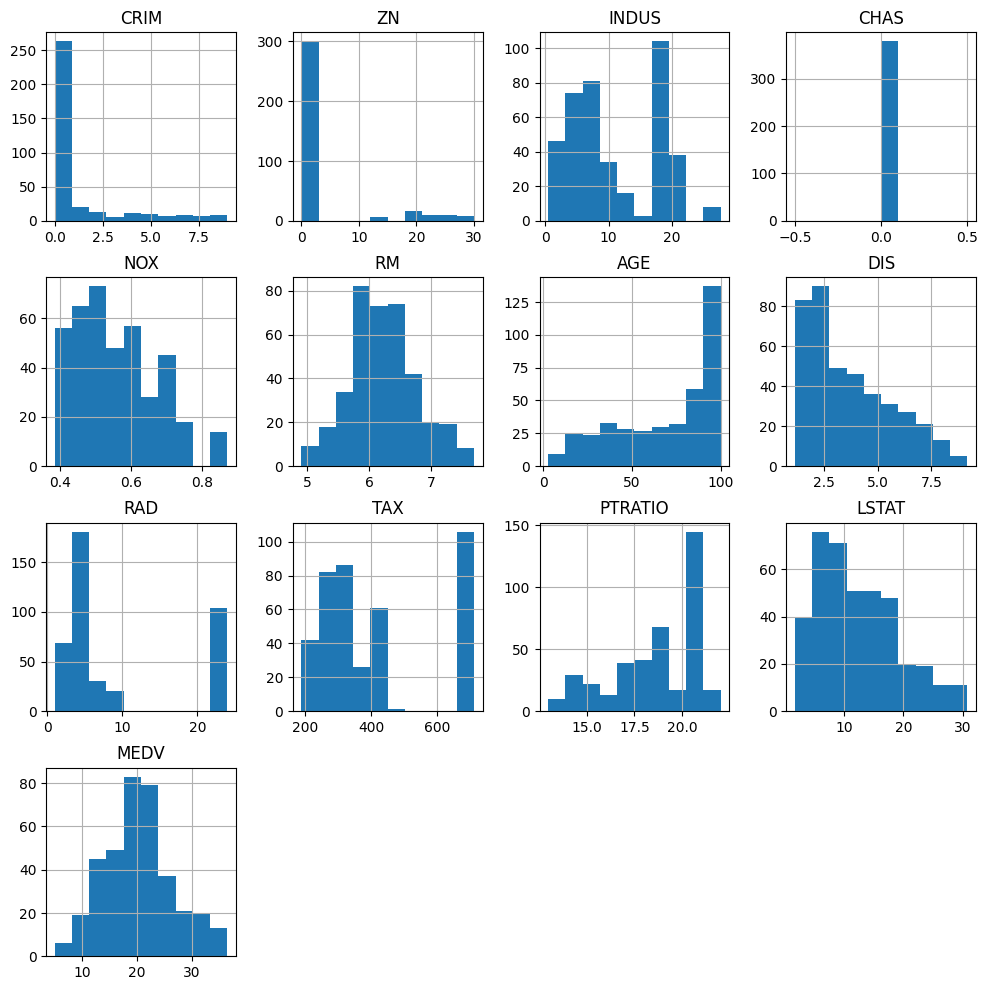

In [126]:
# La mayoría de las columnas tienen distribuciones asímetricas 
clean_train.hist(figsize=(12,12))
plt.show()

In [134]:
skew = pd.DataFrame(index=clean_train.columns)

skew['original'] = clean_train.skew()
skew['log'] = np.log(clean_train).skew()
skew['sqrt'] = np.sqrt(clean_train).skew()
skew['inv'] = np.power(clean_train, -1).skew()

In [135]:
skew

,original,log,sqrt,inv
CRIM,2.078339,0.421994,1.446541,3.685225
ZN,2.296966,NaN,2.141558,NaN
INDUS,0.269250,-0.674601,-0.090908,4.787928
CHAS,0.000000,NaN,0.000000,NaN
NOX,0.724537,0.355387,0.533729,-0.031556
RM,0.226895,-0.032612,0.098729,0.305790
AGE,-0.606119,-1.644133,-0.964751,7.036154
DIS,0.762814,0.066208,0.418729,0.677737
RAD,1.024601,0.292517,0.839237,2.440137
TAX,0.702166,0.360771,0.552431,0.157617


In [136]:
transformations = {char: skew.columns[np.argmin(np.abs(skew.loc[char]))] for char in skew.index}
transformations

{'CRIM': 'log',
 'ZN': 'sqrt',
 'INDUS': 'sqrt',
 'CHAS': 'original',
 'NOX': 'inv',
 'RM': 'log',
 'AGE': 'original',
 'DIS': 'log',
 'RAD': 'log',
 'TAX': 'inv',
 'PTRATIO': 'original',
 'LSTAT': 'sqrt',
 'MEDV': 'sqrt'}

In [137]:
def transform_column(data, how='original'):
    if how == 'original':
        trans = data
    elif how == 'log':
        trans = np.log(data)
    elif how == 'sqrt':
        trans = np.sqrt(data)
    elif how == 'inv':
        trans = 1 / data
    else:
        raise ValueError(f'Method {how} does not exist')
    
    return trans

In [139]:
trans_train = pd.DataFrame()

for col in clean_train.columns:
    col_name = col + '_' + transformations[col]
    trans_train[col_name] = transform_column(clean_train[col], transformations[col])

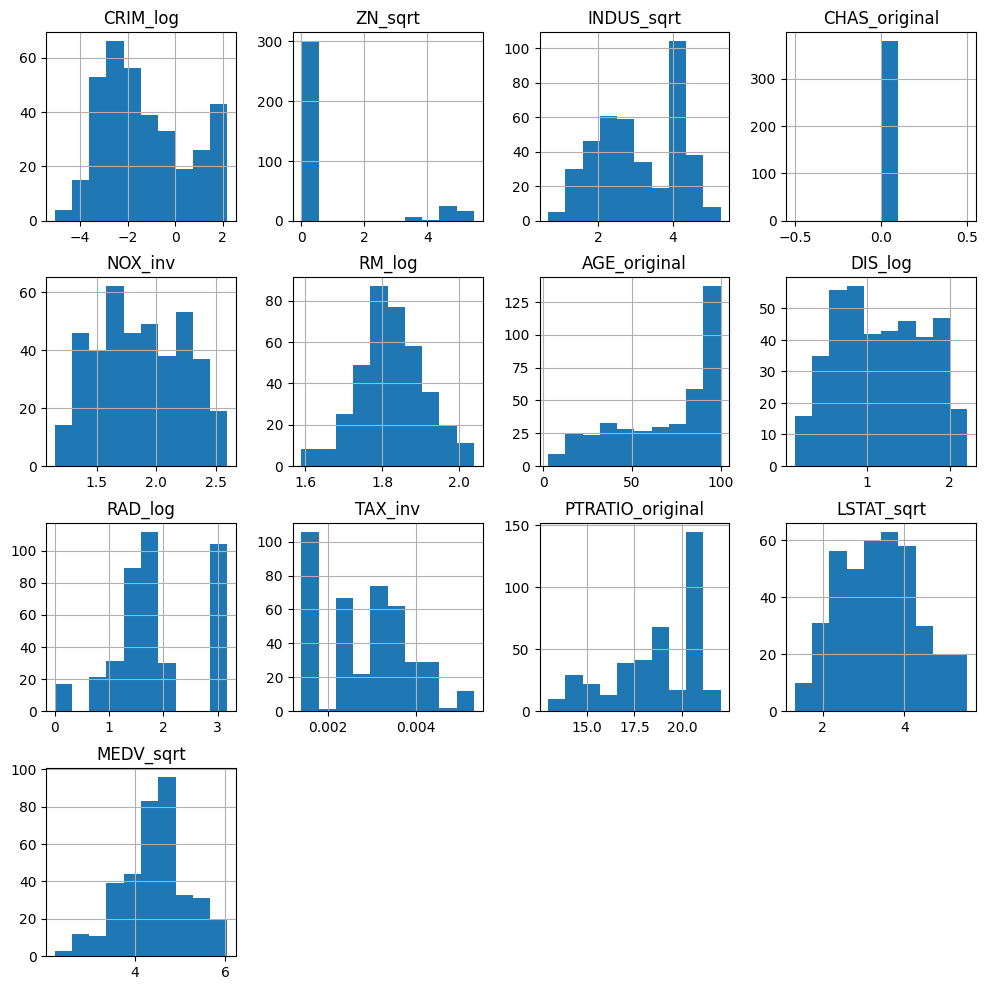

In [140]:
# Si bien no son perfectas, tienen una simetría más cercana a 0
trans_train.hist(figsize=(12,12))
plt.show()

Código de solución estudiante 2

In [ ]:
# Código de solución estudiante 2
.
.
.
.


### Ejercicio 2: 
Construir una red neuronal MLP multivariada. Para esto, tomar todas las variables incluidas en nuestro dataset.

Código de solución estudiante 1

In [0]:
# Código de solución estudiante 1
.
.
.
.


Código de solución estudiante 2

In [0]:
# Código de solución estudiante 2
.
.
.
.


### Ejercicio 3: 
Construir una red neuronal MLP multivariada, pero en este caso sólo considerar las variables adecuadas y descartar aquellas que no aportan mucha información o que son redundantes para cuantificar el efecto de estas variables redundantes.

Luego del paso 3, crear el mismo modelo pero en este caso implementar técnicas de regularización `EarlyStoppin` y `dropout`. Investigar como se pueden implementar estas estrategias en tensorflow.

Código de solución estudiante 1

In [0]:
# Código de solución estudiante 1
.
.
.
.


Código de solución estudiante 2

In [0]:
# Código de solución estudiante 2
.
.
.
.
